<a href="https://colab.research.google.com/github/charlie2099/Shark-Image-Classifier-CNN/blob/main/Shark_Image_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Creative Task:** An image classifier for identifying dangerous species of shark using a Convolutional Neural Network (CNN) and transfer learning methods
###**Application:** A marine life detection system that would be able to correctly identify and classify sharks in an area; determining the level of threat they pose to any nearby divers or swimmers. Through the use of a mobile app an alert could be sent out notifying users of this information. 


###**Useful Sources:** Sources utilised to help learn about CNNs and how to construct them. Also referenced in report bibliography


####Source 1: https://classroom.udacity.com/courses/ud188

####Source 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

####Source 3: https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb

#Preparation

###Importing The Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip '/content/gdrive/MyDrive/shark_dataset_v3.zip' > /dev/null

###Import Libraries

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# utilise GPU if CUDA available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('Training on CPU.')
else:
  print('Training on GPU.')

print(torch.__version__)

Training on GPU.
1.10.0+cu111


###Variables

In [53]:
data_dir = 'shark_dataset_v3/shark_dataset' #dataset directory 
shark_list = ["Great White", "Leopard Shark", "Oceanic Whitetip", "Whale Shark"]
image_res = 32
image_crop = 224
rand_rot = 5
mean_norm = [0.485, 0.456, 0.406]           #normalised mean
std_norm = [0.229, 0.224, 0.225]            #normalised standard deviation

#Hyperparameters
num_of_epochs = 30
batch_size = 4 #100 for t-SNE
learning_rate = 0.001
num_of_class = 4

###Transforms Setup (MLP and CNN)

In [120]:
transform = transforms.Compose([transforms.Resize(image_res), 
                                transforms.CenterCrop(image_res), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5])]) 

# Training, Validation and Testing directorys
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# data loaders preparation
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

###Transforms Setup (Transfer Learning)

In [54]:
train_transform = transforms.Compose([transforms.Resize(image_crop),
                                transforms.RandomRotation(rand_rot), 
                                transforms.CenterCrop(image_crop),
                                transforms.RandomGrayscale(),
                                #transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_norm, std_norm)])

transform = transforms.Compose([transforms.Resize(image_crop), 
                                transforms.CenterCrop(image_crop), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean_norm, std_norm)])

# Training, Validation and Testing directorys
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# data loaders preparation
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

###Displaying Images Through imShow function (Note: Adjust parameters accordingly first)

In [32]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        #mean = np.array([0.5, 0.5, 0.5]) #MLP and #CNN
        #std = np.array([0.5, 0.5, 0.5]) 
        mean = np.array(mean_norm) #CNN with Pretrained Network, t-SNE
        std = np.array(std_norm)
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

###Displaying An Initial Batch of Images

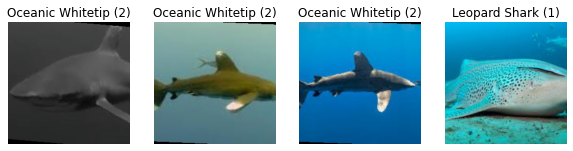

In [33]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, normalize=True)

    if labels[i].item() == 0:
      ax.set_title(shark_list[0]+' ('+ str(labels[i].item())+')')   
    if labels[i].item() == 1:
      ax.set_title(shark_list[1]+' ('+ str(labels[i].item())+')') 
    if labels[i].item() == 2:
      ax.set_title(shark_list[2]+' ('+ str(labels[i].item())+')') 
    if labels[i].item() == 3:
      ax.set_title(shark_list[3]+' ('+ str(labels[i].item())+')') 

#Multi-layer Perceptron (MLP) Classifier (initially: 30%) (best: 52%)

###MLP Network Architecture Setup

In [109]:
input_size = image_res * image_res * 3                                                              

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        hidden_1 = 1028
        hidden_2 = 512
        hidden_3 = 256
        numberOfClasses = 4
      
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, numberOfClasses) 
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
  
        x = x.view(-1, input_size)
      
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
       
        x = F.log_softmax(self.fc4(x), dim=1) 
        return x

model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=1028, bias=True)
  (fc2): Linear(in_features=1028, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###Loss and Optimizer Initialisation

In [110]:
criterion = nn.NLLLoss() # loss function 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam optimiser

###Training The Network

In [111]:
training_losses = [] 
validation_losses = []

valid_loss_min = np.Inf 

for epoch in range(num_of_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train() 
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in val_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MLP_model.pt') 
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/MLP_model.pt') 
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.585321 	Validation Loss: 1.236513
Validation loss decreased (inf --> 1.236513).  Saving model ...
Epoch: 2 	Training Loss: 1.607781 	Validation Loss: 1.673837
Epoch: 3 	Training Loss: 1.420883 	Validation Loss: 1.155239
Validation loss decreased (1.236513 --> 1.155239).  Saving model ...
Epoch: 4 	Training Loss: 1.571595 	Validation Loss: 1.185403
Epoch: 5 	Training Loss: 1.884286 	Validation Loss: 1.866099
Epoch: 6 	Training Loss: 1.639306 	Validation Loss: 1.252648
Epoch: 7 	Training Loss: 1.521477 	Validation Loss: 1.359186
Epoch: 8 	Training Loss: 1.210766 	Validation Loss: 1.355589
Epoch: 9 	Training Loss: 1.389758 	Validation Loss: 1.190674
Epoch: 10 	Training Loss: 1.283497 	Validation Loss: 1.659190
Epoch: 11 	Training Loss: 2.045511 	Validation Loss: 1.263925
Epoch: 12 	Training Loss: 1.743617 	Validation Loss: 1.267725
Epoch: 13 	Training Loss: 1.211699 	Validation Loss: 1.248096
Epoch: 14 	Training Loss: 1.274948 	Validation Loss: 1.312529
Epoch: 1

###Visualising The Results By Plotting Them To a Graph

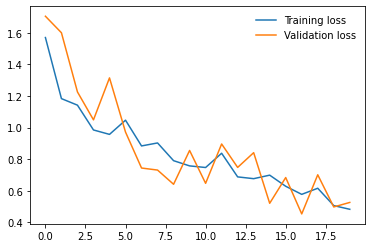

In [116]:
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [117]:
# Load Lowest Validation Loss model
model.load_state_dict(torch.load('MLP_model.pt'))

<All keys matched successfully>

###Evaluating The Test Accuracy Results

In [118]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        if i == 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Great Whites     ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 1:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Leopard Sharks   ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 2:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Oceanic Whitetips", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 3:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Whale Sharks     ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.234012

Test Accuracy of Great Whites     : 38% ( 7/18)
Test Accuracy of Leopard Sharks   : 26% ( 4/15)
Test Accuracy of Oceanic Whitetips: 70% (12/17)
Test Accuracy of Whale Sharks     : 20% ( 4/20)

Test Accuracy (Overall): 38% (27/70)


###Visualising How Well The Network Performed

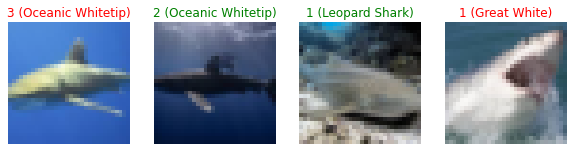

In [119]:
data_iterator = iter(test_loader)
images, labels = data_iterator.next()

m_output = model(images)
_, prediction = torch.max(m_output, 1)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, normalize=True)

    if labels[i].item() == 0:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[0]),
                 color=("green" if prediction[i]==labels[i] else "red")) 
    if labels[i].item() == 1:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[1]),
                 color=("green" if prediction[i]==labels[i] else "red")) 
    if labels[i].item() == 2:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[2]),
                 color=("green" if prediction[i]==labels[i] else "red")) 
    if labels[i].item() == 3:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[3]),
                 color=("green" if prediction[i]==labels[i] else "red")) 

#0 Great White
#1 Leopard shark
#2 Oceanic Whitetip
#3 Whale shark

#Convolutional Neural Network (initially: 44%) (best: 65%)

###CNN Architecture Setup

In [123]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
    
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
      
        self.pool = nn.MaxPool2d(2, 2) 
      
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 4) 
    
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
  
        x = x.view(-1, 64 * 4 * 4)

        x = self.dropout(x)
     
        x = F.relu(self.fc1(x))
    
        x = self.dropout(x)
    
        x = self.fc2(x)
        
        return x

model = Network()
print(model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


###Loss and Optimizer Initialisation

In [124]:
criterion = nn.CrossEntropyLoss() # loss function 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam optimiser

###Training The Network

In [125]:
training_losses = []
validation_losses = []

valid_loss_min = np.Inf 

for epoch in range(num_of_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train() 
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
          
    model.eval() 
    for data, target in val_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt') # save in colab
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_model.pt') # save in google drive
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.330731 	Validation Loss: 1.314313
Validation loss decreased (inf --> 1.314313).  Saving model ...
Epoch: 2 	Training Loss: 1.240975 	Validation Loss: 1.143507
Validation loss decreased (1.314313 --> 1.143507).  Saving model ...
Epoch: 3 	Training Loss: 1.174455 	Validation Loss: 1.164415
Epoch: 4 	Training Loss: 1.165578 	Validation Loss: 1.168423
Epoch: 5 	Training Loss: 1.125882 	Validation Loss: 1.181532
Epoch: 6 	Training Loss: 1.103505 	Validation Loss: 1.179568
Epoch: 7 	Training Loss: 1.025192 	Validation Loss: 1.129516
Validation loss decreased (1.143507 --> 1.129516).  Saving model ...
Epoch: 8 	Training Loss: 1.028620 	Validation Loss: 1.021351
Validation loss decreased (1.129516 --> 1.021351).  Saving model ...
Epoch: 9 	Training Loss: 0.962623 	Validation Loss: 1.046721
Epoch: 10 	Training Loss: 0.902972 	Validation Loss: 1.060318
Epoch: 11 	Training Loss: 0.886774 	Validation Loss: 1.195989
Epoch: 12 	Training Loss: 0.851237 	Validation Loss: 1.1

###Plotting The Training and Validation Losses To a Graph

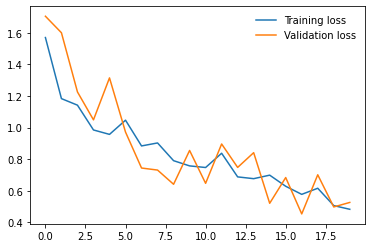

In [126]:
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('CNN_model.pt'))

<All keys matched successfully>

###Test Accuracy Results

In [129]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
 
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        if i == 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Great Whites     ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 1:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Leopard Sharks   ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 2:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Oceanic Whitetips", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
        if i == 3:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              "Whale Sharks     ", 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.028421

Test Accuracy of Great Whites     : 66% (12/18)
Test Accuracy of Leopard Sharks   : 73% (11/15)
Test Accuracy of Oceanic Whitetips: 47% ( 8/17)
Test Accuracy of Whale Sharks     : 65% (13/20)

Test Accuracy (Overall): 62% (44/70)


###Visualising The Test Results, Seeing How The Network Performed

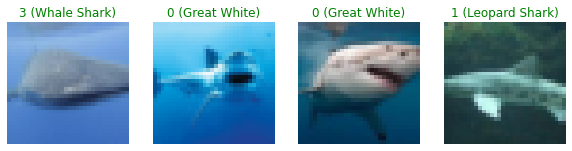

In [132]:
data_iterator = iter(test_loader)
images, labels = data_iterator.next()

m_output = model(images)
_, prediction = torch.max(m_output, 1)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images[i], ax=ax, normalize=True)
    
    if labels[i].item() == 0:
          ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[0]),
                    color=("green" if prediction[i]==labels[i] else "red")) 
    if labels[i].item() == 1:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[1]),
                color=("green" if prediction[i]==labels[i] else "red")) 
    if labels[i].item() == 2:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[2]),
                color=("green" if prediction[i]==labels[i] else "red")) 
    if labels[i].item() == 3:
      ax.set_title("{} ({})".format(str(prediction[i].item()), shark_list[3]),
                color=("green" if prediction[i]==labels[i] else "red")) 

#Transfer Learning (initially: 70%) (best: 90%)

###ResNet18 Architecture Setup

In [40]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, num_of_class)

if train_on_gpu:
    model.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###Loss and Optimizer Initialisation

In [41]:
criterion = nn.CrossEntropyLoss() # loss function 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Adam optimiser

###Training The Network

In [42]:
training_losses = []
validation_losses = []

valid_loss_min = np.Inf 

for epoch in range(num_of_epochs):
  
    train_loss = 0.0
    valid_loss = 0.0
    
  
    model.train()
    for data, target in train_loader:
    
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
    
        optimizer.zero_grad()

        output = model(data)
   
        loss = criterion(output, target)
  
        loss.backward()
 
        optimizer.step()
  
        train_loss += loss.item()*data.size(0)
          
    model.eval() 
    for data, target in val_loader:
 
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
    
        output = model(data)
 
        loss = criterion(output, target)
    
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') 
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt') 
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.397643 	Validation Loss: 7.307586
Validation loss decreased (inf --> 7.307586).  Saving model ...
Epoch: 2 	Training Loss: 1.223603 	Validation Loss: 3.303600
Validation loss decreased (7.307586 --> 3.303600).  Saving model ...
Epoch: 3 	Training Loss: 1.143188 	Validation Loss: 0.860343
Validation loss decreased (3.303600 --> 0.860343).  Saving model ...
Epoch: 4 	Training Loss: 0.986222 	Validation Loss: 0.980455
Epoch: 5 	Training Loss: 1.050763 	Validation Loss: 2.301142
Epoch: 6 	Training Loss: 1.074774 	Validation Loss: 0.869955
Epoch: 7 	Training Loss: 0.997500 	Validation Loss: 0.876609
Epoch: 8 	Training Loss: 0.979748 	Validation Loss: 1.314945
Epoch: 9 	Training Loss: 0.864597 	Validation Loss: 0.711253
Validation loss decreased (0.860343 --> 0.711253).  Saving model ...
Epoch: 10 	Training Loss: 0.919486 	Validation Loss: 1.200865
Epoch: 11 	Training Loss: 0.673805 	Validation Loss: 0.688148
Validation loss decreased (0.711253 --> 0.688148).  Savi

###Plotting The Training and Validation Losses To a Graph

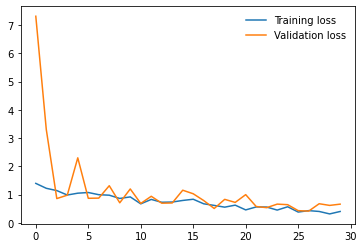

In [47]:
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

In [44]:
# Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

###Test Accuracy Results

In [45]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_of_class):
    if class_total[i] > 0:
      if i == 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Great Whites     ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      if i == 1:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Leopard Sharks   ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      if i == 2:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Oceanic Whitetips", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
      if i == 3:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            "Whale Sharks     ", 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.504282

Test Accuracy of Great Whites     : 83% (15/18)
Test Accuracy of Leopard Sharks   : 66% (10/15)
Test Accuracy of Oceanic Whitetips: 94% (16/17)
Test Accuracy of Whale Sharks     : 90% (18/20)

Test Accuracy (Overall): 84% (59/70)


###Visualising How Well The Network Performed

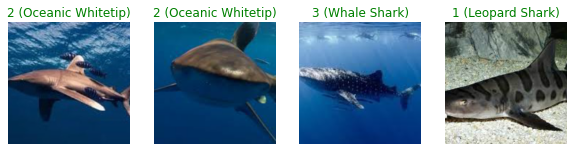

In [46]:
data_iterator = iter(test_loader)
images, labels = data_iterator.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes[i]
    imshow(images.cpu()[i], ax=ax, normalize=True)

    if(labels[i].item() == 0):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[0]),
                   color=("green" if preds[i]==labels[i] else "red")) 
    if(labels[i].item() == 1):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[1]),
                   color=("green" if preds[i]==labels[i] else "red")) 
    if(labels[i].item() == 2):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[2]),
                   color=("green" if preds[i]==labels[i] else "red")) 
    if(labels[i].item() == 3):
      ax.set_title("{} ({})".format(str(preds[i].item()), shark_list[3]),
                   color=("green" if preds[i]==labels[i] else "red")) 

#Visualising class features with t-SNE

###Loading The Pre-trained Model (ResNet18)

In [55]:
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])

if train_on_gpu:
    model.cuda()

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [50]:
# Load previously trained model

# create a new model with ResNet18 architecture
myModel = models.resnet18(pretrained=True)
# get the number of inputs for the final layer (fc) of the network
num_ftrs = myModel.fc.in_features
# replace the final layer so that the output is four classes
myModel.fc = nn.Linear(num_ftrs, 4)
# load previously trained model
myModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
# remove the final layer so the output of the network is now a 512 feature vector
myModel = nn.Sequential(*list(myModel.children())[:-1])

# move tensors to GPU if CUDA is available
if train_on_gpu:
    myModel.cuda()

# print(myModel)

###Feature Results

In [56]:
data_iterator = iter(test_loader)
images, labels = data_iterator.next()

if train_on_gpu:
    images = images.cuda()

imageNet_feats = model(images)
sharks_feats = myModel(images)

imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
sharks_feats = np.squeeze(sharks_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(sharks_feats.shape)
print(labels)

(70, 512)
(70, 512)
[1 0 3 2 3 3 1 0 2 0 1 2 0 3 3 3 2 0 3 3 1 1 3 2 1 2 0 0 3 2 1 1 0 1 3 0 0
 2 3 2 3 0 0 2 3 1 0 1 0 3 2 2 3 1 3 0 1 2 1 2 3 2 3 0 3 2 0 0 2 1]


###Plotting The Results Onto a Graph

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


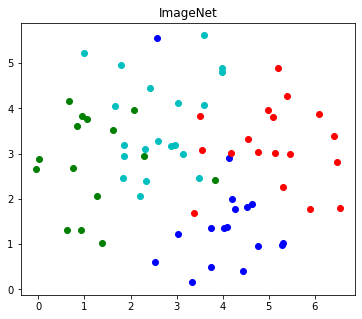

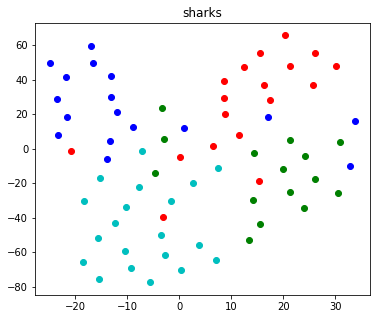

In [57]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0) 

imageNet_X_2d = tsne.fit_transform(imageNet_feats)
sharks_X_2d = tsne.fit_transform(sharks_feats)

plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 Great White Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 Leopard Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2 Oceanic Whitetip Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 Whale Shark
    plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')
plt.title('ImageNet')
# plt.show()

plt.figure(figsize=(6, 5))
for i in range(sharks_X_2d.shape[0]):
  if labels[i] == 0:
    # 0 Great White Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='r')
  if labels[i] == 1:
    # 1 Leopard Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='g')
  if labels[i] == 2:
    # 2  Oceanic Whitetip Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='b')
  if labels[i] == 3:
    # 3 Whale Shark
    plt.scatter(sharks_X_2d[i,0], sharks_X_2d[i, 1], c='c')
plt.title('sharks')
# plt.show()
plt.show()

<font color='red'>**RED**</font>: Great White, <font color='green'>**GREEN**</font>: Leopard, <font color='blue'>**BLUE**</font>: Oceanic Whitetip, <font color='cyan'>**CYAN**</font>: Whale  

# Visualising How The Network Identifies Features With Class Activation Maps (SmoothGradCAM++) 

###Cloning the SmoothGradCAM repository 

In [ ]:
!git clone https://github.com/yiskw713/SmoothGradCAMplusplus.git

Cloning into 'SmoothGradCAMplusplus'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 47 (delta 13), reused 24 (delta 11), pack-reused 20
Unpacking objects: 100% (47/47), done.


In [ ]:
%cd /content/SmoothGradCAMplusplus/

/content/SmoothGradCAMplusplus


In [ ]:
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

###Preprocessing Transforms

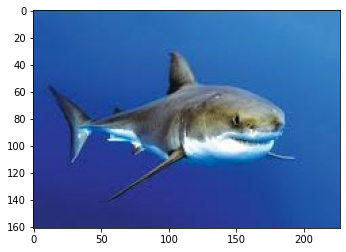

In [ ]:
image = Image.open('/content/shark_dataset_v3/shark_dataset/train/great_white/great_white (18).jpg') # Great White 
#image = Image.open('/content/shark_dataset_v3/shark_dataset/train/leopard/leopard (5).jpg')           # Leopard shark
#image = Image.open('/content/shark_dataset_v3/shark_dataset/train/oceanic_whitetip/oceanic_whitetip (17).jpg')           # Oceanic Whitetip 
#image = Image.open('/content/shark_dataset_v3/shark_dataset/train/whale/whale (79).jpg')           # Whale shark

imshow(image)

In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

tensor = preprocess(image)

tensor = tensor.unsqueeze(0)

###Evaluating The Model

In [ ]:
model = models.resnet18(pretrained=True)
model.eval()
# print(model)

target_layer = model.layer4[1].conv2

# wrappers 
#wrapped_model = CAM(model, target_layer)
#wrapped_model = GradCAM(model, target_layer)
#wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

cam, idx = wrapped_model(tensor)
print(idx2label[idx])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


predicted class ids 2	 probability 0.9324156641960144
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias


###Visualising The Cam Heatmap

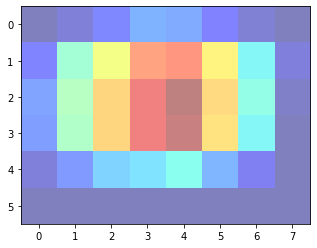

In [ ]:
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')

###Visualising The Shark Heatmap

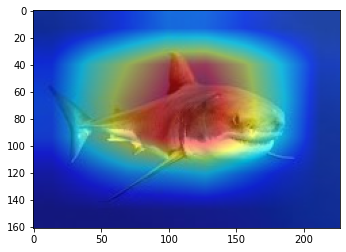

In [ ]:
img = reverse_normalize(tensor)

heatmap = visualize(img, cam)

# save_image(heatmap, './sample/{}_cam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcam.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
# save_image(heatmap, './sample/{}_gradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))
save_image(heatmap, './sample/{}_smoothgradcampp.png'.format(idx2label[idx]).replace(" ", "_").replace(",", ""))

hm = (heatmap.squeeze().numpy().transpose(1, 2, 0))
imshow(hm)